# Imitation Learning for PI-Mobile

In [1]:
import six
import pandas               as pd
import numpy                as np
from IPython.display        import display
import matplotlib.pyplot    as plt
import seaborn              as sns
import math
import folium
import progressbar
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows', 100)
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Statistical packages used for transformations
from scipy              import stats
from scipy.stats        import skew, norm
from scipy.special      import boxcox1p
from scipy.stats.stats  import pearsonr

print('Statistical packages imported!')

# Metrics used for measuring the accuracy and performance of the models
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Algorithms used for modeling
from sklearn.linear_model   import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble       import RandomForestClassifier,  GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.kernel_ridge   import KernelRidge
import xgboost              as xgb

print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline           import make_pipeline
from sklearn.preprocessing      import RobustScaler
from sklearn.preprocessing      import StandardScaler
from sklearn.preprocessing      import LabelEncoder
from sklearn.feature_selection  import SelectFromModel
from sklearn.feature_selection  import SelectKBest
from sklearn.feature_selection  import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters

from sklearn                    import model_selection
from sklearn.model_selection    import KFold
from sklearn.model_selection    import cross_val_score, train_test_split
from sklearn.model_selection    import GridSearchCV
from sklearn.model_selection    import ShuffleSplit
print('Model selection packages imported!')

import tensorflow as tf

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
sns.set_style('darkgrid')
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Metrics packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!


In [2]:
import cv2
from os import listdir
from os.path import isfile, join
import progressbar

# Extracting frames : 

The goal here is to extract frames from the video we recorded while driving the car. We extract here 10 frames per second.

In [3]:
video_folder = 'SelfDriving/Video/'
img_folder = 'SelfDriving/Images/'
videos_files = [f for f in listdir(video_folder) if isfile(join(video_folder, f))]

In [4]:
videos_files

['test_1.mp4',
 'test_3.mp4',
 'test_2.mp4',
 'test_6.mp4',
 'test_7.mp4',
 'test_5.mp4',
 'test_4.mp4',
 'test_8.mp4']

In [5]:
# Getting the FPS of our recorded video :
test_path = video_folder + 'test_1.mp4'
cap= cv2.VideoCapture(test_path)
# ~30 : dividing by 3 to get ~10 FPS
fps = cap.get(cv2.CAP_PROP_FPS)/3.
cap.release()

def get_time_from_frame(img_path):
    indx = int(img_path[img_path.find('_frame_')+7:-4])
    return indx/fps


In [52]:
# Extracting the frames from each vdeo : 

for video_name in progressbar.progressbar(videos_files):
    print("Extracting {}".format(video_name))
    video_full_path = video_folder + video_name
    
    cap= cv2.VideoCapture(video_full_path)
    i=0
    while(cap.isOpened()):
        name_frame = img_folder + video_name + "_frame_" + str(i//3) + '.jpg'
        ret, frame = cap.read()
        if ret == False:
            break
        if i%3 == 0:
            cv2.imwrite(name_frame,frame)
        i+=1

    cap.release()
    cv2.destroyAllWindows()

N/A% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Extracting test_1.mp4


 12% (1 of 8) |###                       | Elapsed Time: 0:00:07 ETA:   0:00:54

Extracting test_3.mp4


 25% (2 of 8) |######                    | Elapsed Time: 0:00:18 ETA:   0:01:03

Extracting test_2.mp4


 37% (3 of 8) |#########                 | Elapsed Time: 0:00:26 ETA:   0:00:40

Extracting test_6.mp4


 50% (4 of 8) |#############             | Elapsed Time: 0:00:29 ETA:   0:00:11

Extracting test_7.mp4


 62% (5 of 8) |################          | Elapsed Time: 0:00:53 ETA:   0:01:10

Extracting test_5.mp4


 75% (6 of 8) |###################       | Elapsed Time: 0:00:57 ETA:   0:00:08

Extracting test_4.mp4


 87% (7 of 8) |######################    | Elapsed Time: 0:01:31 ETA:   0:00:34

Extracting test_8.mp4


100% (8 of 8) |##########################| Elapsed Time: 0:02:08 Time:  0:02:08


# Handling Inputs :

Here, we take care of the control and the inputs. The goal is to link them to each frame. When a frame occurs between 2 inputs, we link it with the one occuring just before.

In [6]:
import PIL
from PIL import Image

## Hardcode conditions for turning frames : 

In [7]:
# 1
frame_left_1 = ['test_3.mp4_frame_'+str(i)+'.jpg' for i in range(50,100)]
frame_left_2 = ['test_4.mp4_frame_'+str(i)+'.jpg' for i in range(1330,1371)]
frame_left_3 = ['test_4.mp4_frame_'+str(i)+'.jpg' for i in range(1507,1548)]
frame_left = frame_left_1 + frame_left_2 + frame_left_3

In [8]:
# 2
frame_right_1 = ['test_7.mp4_frame_' + str(i)+'.jpg' for i in range(926,964)]
frame_right_2 = ['test_7.mp4_frame_' + str(i)+'.jpg' for i in range(1119,1150)]
frame_right_3 = ['test_8.mp4_frame_' + str(i)+'.jpg' for i in range(1481,1537)]
frame_right = frame_right_1 + frame_right_2 + frame_right_3

In [9]:
# 0 
frame_forward = ['test_1.mp4_frame_' + str(i)+'.jpg' for i in range(265,288)]

In [10]:
data_folder = 'SelfDriving/Data/'
import json 
def mapping_data(dict_data):
    new_inputs = []
    new_time = []
    start_time = dict_data['time'][0]
    for key,time in zip(dict_data['key'],dict_data['time']):
        if key == '8':
            new_inputs.append(0)
        elif key == '6':
            new_inputs.append(1)
        elif key == '4':
            new_inputs.append(2)
        else: 
            new_inputs.append(0)
        new_time.append(time - start_time)
    return new_inputs, new_time

In [11]:
img_to_data = {
    'test_1': mapping_data(json.load(open(data_folder+'data_1.json'))),
    'test_2': mapping_data(json.load(open(data_folder+'data_2.json'))),
    'test_3': mapping_data(json.load(open(data_folder+'data_3.json'))),
    'test_4': mapping_data(json.load(open(data_folder+'data_4.json'))),
    'test_5': mapping_data(json.load(open(data_folder+'data_5.json'))),
    'test_6': mapping_data(json.load(open(data_folder+'data_6.json'))),
    'test_8': mapping_data(json.load(open(data_folder+'data_8.json')))
}

In [12]:
data_inputs = {
    'inputs': [],
    'time': [],
    'frame':[],
    'condition':[]
}

In [13]:
def _get_img(img_path):
    img = np.array(Image.open(img_folder+img_path).resize((224,224)))
    return img
def _get_condition(img_path):
    if img_path in frame_left:
        return 1
    elif img_path in frame_right:
        return 2
    else:
        return 0

In [14]:
full_imgs = [f for f in listdir(img_folder) if isfile(join(img_folder, f))]

In [117]:
for img_path in progressbar.progressbar(full_imgs):
    video_name = img_path[0:6]
    if video_name != 'test_7':
        
        key_inputs,time_inputs = img_to_data[video_name]
        
        time_code = get_time_from_frame(img_path)
        i = 0
        img = _get_img(img_path)
        condition = _get_condition(img_path)

        if time_code < 0.001:
            data_inputs['inputs'].append(key_inputs[0])
            data_inputs['time'].append(0.0)
            data_inputs['frame'].append(img)
            data_inputs['condition'].append(condition)
        else:
            while time_inputs[i] < time_code:
                i += 1
            data_inputs['inputs'].append(key_inputs[i-1])
            data_inputs['time'].append(time_inputs[i-1])
            data_inputs['frame'].append(img)
            data_inputs['condition'].append(condition)
            
        

100% (9063 of 9063) |####################| Elapsed Time: 0:01:36 Time:  0:01:36


In [118]:
full_imgs = data_inputs['frame']
full_data = {
    'inputs':data_inputs['inputs'],
    'time':data_inputs['time'],
    'condition':data_inputs['condition']
}

In [119]:
with open('SelfDriving/Data/full_data.json', 'w') as fp:
    json.dump(full_data, fp)

In [120]:
full_imgs = np.array(full_imgs)

In [121]:
np.save('SelfDriving/Data/full_imgs.npy',full_imgs)

In [13]:
full_img = np.load('SelfDriving/Data/full_imgs.npy')

# Small Data Analysis : 

In [14]:
import json

In [15]:
full_data = json.load(open('SelfDriving/Data/full_data.json'))

In [125]:
df = pd.DataFrame(full_data)

In [126]:
df

,inputs,time,condition
0,2,2.588967,0
1,0,41.692584,0
2,2,138.952270,0
3,0,0.000000,0
4,0,34.373897,0
...,...,...,...
7404,0,8.504497,0
7405,1,15.875353,0
7406,0,195.907482,0
7407,2,43.297339,0


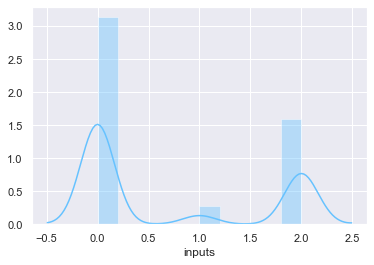

In [127]:
ax = sns.distplot(df['inputs'])

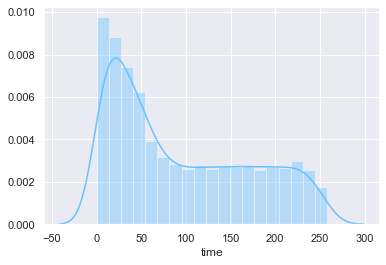

In [128]:
ax = sns.distplot(df['time'])

# Training a simple first model:

In [16]:
from keras import backend as K
from keras import __version__
import keras
# Pour charger notre modèle : 
from keras.models import Model
from keras.models import load_model

# Pour modifier notre modèle : 
from keras.layers import Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import SGD
from keras.utils import plot_model

# Pour modifier nos images et les utiliser : 

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [17]:
from keras.applications import MobileNet

In [18]:
model = MobileNet(input_shape=(224,224,3),include_top=False,weights=None)

In [20]:
def _build_model(model):
    inputs_mobilenet = model.input
    
    x = model.output
    x = AveragePooling2D((4,4), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x) 
    merged = x
    x = Dense(2048,activation='relu')(merged)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    
    full_model = Model(inputs=inputs_mobilenet,outputs=predictions)
    
    return full_model

In [21]:
full_model = _build_model(model)

# Training : 

In [23]:
from sklearn.model_selection    import train_test_split
Y = full_data['inputs']
X_img = full_img/255.
X_condition = full_data['condition']

In [24]:
Y_ = [] 
for y in Y:
    if y == 0:
        Y_.append(np.array([1,0,0]))
    elif y == 1:
        Y_.append(np.array([0,1,0]))
    else:
        Y_.append(np.array([0,0,1]))
Y = np.array(Y_)

In [25]:
X_condition_ = []
for x in X_condition:
    X_condition_.append(np.array(x))
X_condition = np.array(X_condition_)

In [26]:
full_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

### Increase Dataset Size : 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_img, Y, test_size=0.33, random_state=42)

In [28]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    height_shift_range=0.1,
    brightness_range=[0.5,1.2],
    zoom_range = [0.8,1.2])

In [29]:
datagen.fit(X_train)

In [31]:
history = full_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=1)

Epoch 1/1
156/155 [==============================] - 549s 4s/step - loss: 0.9277 - accuracy: 0.6118
